In [8]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize(project = "kolkata-flood-mapping")
print("Earth Engine initialized")

Earth Engine initialized


In [9]:
# Define Kolkata boundary
kolkata = ee.Geometry.Rectangle([88.20, 22.45, 88.50, 22.65])

# Load SRTM elevation
srtm = ee.Image('USGS/SRTMGL1_003')
elevation = srtm.clip(kolkata)

# Clean the data (remove water artifacts)
elevation_masked = elevation.updateMask(
    elevation.gt(0).And(elevation.lt(30))
)

In [10]:
# Calculate stats
stats = elevation_masked.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        ee.Reducer.minMax(), 
        sharedInputs=True
    ),
    geometry=kolkata,
    scale=30,
    maxPixels=1e9
)

# Get the values
stats_dict = stats.getInfo()
print(f"Mean elevation: {stats_dict['elevation_mean']:.2f} meters")
print(f"Min elevation: {stats_dict['elevation_min']} meters")
print(f"Max elevation: {stats_dict['elevation_max']} meters")

Mean elevation: 6.75 meters
Min elevation: 1 meters
Max elevation: 29 meters


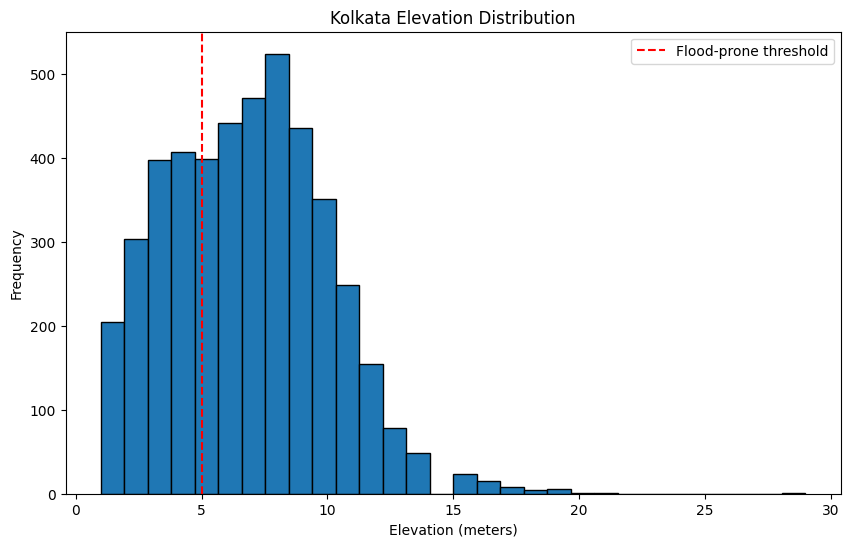

In [16]:
# Sample elevation values for histogram
sample = elevation_masked.sample(
    region=kolkata,
    scale=30,
    numPixels=5000
)

# Convert to pandas DataFrame
sample_df = pd.DataFrame(sample.getInfo()['features'])
sample_df['elevation'] = sample_df['properties'].apply(lambda x: x['elevation'])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sample_df['elevation'], bins=30, edgecolor='black')
plt.xlabel('Elevation (meters)')
plt.ylabel('Frequency')
plt.title('Kolkata Elevation Distribution')
plt.axvline(5, color='red', linestyle='--', label='Flood-prone threshold')
plt.legend()
plt.show()

In [17]:
# Create flood risk zones based on elevation
low_elevation = elevation_masked.lt(5)  # Below 5 meters
medium_elevation = elevation_masked.gte(5).And(elevation_masked.lt(8))
high_elevation = elevation_masked.gte(8)

# Count pixels in each category
pixel_count = low_elevation.addBands([medium_elevation, high_elevation]).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=kolkata,
    scale=30,
    maxPixels=1e9
)

print("Pixel counts by elevation zone:")
print(pixel_count.getInfo())

Pixel counts by elevation zone:
{'elevation': 210882.9843137261, 'elevation_1': 226168.27058823593, 'elevation_1_1': 310988.35686273914}


In [18]:
# Better way to get readable results
low_count = pixel_count.get('elevation').getInfo()
medium_count = pixel_count.get('elevation_1').getInfo()
high_count = pixel_count.get('elevation_1_1').getInfo()

total_pixels = low_count + medium_count + high_count

# Convert to percentages
low_percent = (low_count / total_pixels) * 100
medium_percent = (medium_count / total_pixels) * 100
high_percent = (high_count / total_pixels) * 100

print(f"Elevation Distribution of Kolkata:")
print(f"Below 5m (potentially flood-prone): {low_percent:.1f}%")
print(f"5-8m (moderate elevation): {medium_percent:.1f}%")
print(f"Above 8m (higher ground): {high_percent:.1f}%")

# Convert to area (each pixel is 30m x 30m = 900 sq meters)
pixel_area = 30 * 30 / 1000000  # in sq km
print(f"\nArea in sq km:")
print(f"Low elevation: {low_count * pixel_area:.1f} sq km")
print(f"Medium elevation: {medium_count * pixel_area:.1f} sq km")
print(f"High elevation: {high_count * pixel_area:.1f} sq km")

Elevation Distribution of Kolkata:
Below 5m (potentially flood-prone): 28.2%
5-8m (moderate elevation): 30.2%
Above 8m (higher ground): 41.6%

Area in sq km:
Low elevation: 189.8 sq km
Medium elevation: 203.6 sq km
High elevation: 279.9 sq km


In [19]:
# Optional: Export to Drive from Python
task = ee.batch.Export.image.toDrive(
    image=elevation_masked,
    description='kolkata_elevation_python',
    folder='Earth_Engine_Exports',
    region=kolkata,
    scale=30,
    fileFormat='GeoTIFF'
)

# Start the export
task.start()
print(f"Export started. Task ID: {task.id}")

Export started. Task ID: IGWOLLKWYSQNYKVBTOUAWLW2
